# Testing Sentinel 2 dynamic cloud mask

**License:** Code freely available under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).

**Contact:** If you find an issue with this notebook or need assistance, please post a question on the [OpenDataCube slack channel](https://opendatacube.slack.com), ask a question on StackExchange using the [open-data-cube tag](https://gis.stackexchange.com/questions/tagged/open-data-cube), or file an issue on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** August 2019

### Description
Testing the newly developed Sentinel-2 temporal cloudmask

## Load modules

In [1]:
import datacube
import matplotlib.pyplot as plt
import xarray as xr

# Connect to standard database for Sentinel 2 ARD
dc = datacube.Datacube()

# Set up a custom config to access s2tsmask database
config = {'db_hostname': 'agdcdev-db.nci.org.au',
          'db_port': 6432,
          'db_database': 's2tsmask'}

dc_cloudmask = datacube.Datacube(config=config)

## Load in temporal cloud mask and fmask


In [2]:
dc_cloudmask.list_measurements().loc['s2_tsmask']

,name,dtype,units,nodata,aliases,flags_definition,spectral_definition
measurement,,,,,,,
classification,classification,uint8,1,0,NaN,"{'classification': {'bits': [0, 1, 2, 3, 4, 5,...",NaN


In [3]:
# Set up query 
query = dict(y=(-35.83, -35.93),   
             x=(150.11, 150.21),
             time=('2018-08', '2019-02'),
             output_crs='EPSG:3577', 
             resolution=(-20, 20))
        
# Load in temporal cloudmask data
tsmask_ds = dc_cloudmask.load(product='s2_tsmask', **query)

# Load in Sentinel 2A and 2B fmask
s2a_ds = dc.load(product='s2a_ard_granule', 
                 measurements=['fmask', 'nbart_red', 'nbart_green', 'nbart_blue'], 
                 **query)
s2b_ds = dc.load(product='s2b_ard_granule', 
                 measurements=['fmask', 'nbart_red', 'nbart_green', 'nbart_blue'], 
                 **query)
s2_ds = xr.concat([s2a_ds, s2b_ds], dim='time').sortby('time')


In [4]:
print(tsmask_ds)

<xarray.Dataset>
Dimensions:         (time: 42, x: 527, y: 614)
Coordinates:
  * time            (time) datetime64[ns] 2018-08-03T00:02:39.024000 ... 2019-02-24T00:02:41.024000
  * y               (y) float64 -4.03e+06 -4.03e+06 ... -4.042e+06 -4.042e+06
  * x               (x) float64 1.628e+06 1.629e+06 ... 1.639e+06 1.639e+06
Data variables:
    classification  (time, y, x) uint8 2 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1
Attributes:
    crs:      EPSG:3577


In [5]:
print(s2_ds)

<xarray.Dataset>
Dimensions:      (time: 42, x: 527, y: 614)
Coordinates:
  * y            (y) float64 -4.03e+06 -4.03e+06 ... -4.042e+06 -4.042e+06
  * x            (x) float64 1.628e+06 1.629e+06 ... 1.639e+06 1.639e+06
  * time         (time) datetime64[ns] 2018-08-03T00:02:39.024000 ... 2019-02-24T00:02:41.024000
Data variables:
    fmask        (time, y, x) uint8 2 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 5 5 5 5 5 5
    nbart_red    (time, y, x) int16 3773 3690 3844 3777 3686 ... 313 340 280 259
    nbart_green  (time, y, x) int16 3822 3840 3913 3911 3946 ... 435 456 367 341
    nbart_blue   (time, y, x) int16 3895 3843 3987 3929 3960 ... 568 581 515 499
Attributes:
    crs:      EPSG:3577


### Restrict comparison only to observations in both datasets

In [6]:
# Return only observations that have timesteps in both datasets
matching_times = (tsmask_ds.time - s2_ds.time).time
tsmask_ds = tsmask_ds.sel(time=matching_times)
s2_ds = s2_ds.sel(time=matching_times)

In [7]:
print(tsmask_ds)

<xarray.Dataset>
Dimensions:         (time: 42, x: 527, y: 614)
Coordinates:
  * time            (time) datetime64[ns] 2018-08-03T00:02:39.024000 ... 2019-02-24T00:02:41.024000
  * y               (y) float64 -4.03e+06 -4.03e+06 ... -4.042e+06 -4.042e+06
  * x               (x) float64 1.628e+06 1.629e+06 ... 1.639e+06 1.639e+06
Data variables:
    classification  (time, y, x) uint8 2 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1
Attributes:
    crs:      EPSG:3577


### Print bit flags

In [8]:
# Print temporal cloudmask flags
tsmask_ds.classification.flags_definition

{'classification': {'bits': [0, 1, 2, 3, 4, 5, 6, 7],
  'values': {'0': 'No observation',
   '1': 'Clear',
   '2': 'Cloud',
   '3': 'Cloud shadow'},
  'description': 'TSmask classification'}}

In [9]:
# Print Sentinel 2 fmask flags
s2_ds.fmask.flags_definition

{'fmask': {'bits': [0, 1, 2, 3, 4, 5, 6, 7],
  'values': {'0': 'nodata',
   '1': 'valid',
   '2': 'cloud',
   '3': 'shadow',
   '4': 'snow',
   '5': 'water'},
  'description': 'Fmask'}}

## Compare cloud counts in both datasets

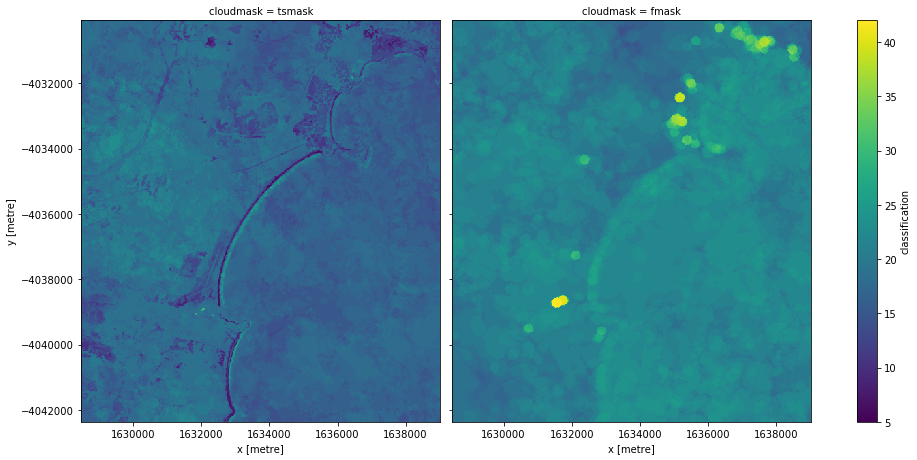

In [10]:
combined_ds = xr.concat([(tsmask_ds.classification == 2).sum(dim='time'), 
                         (s2_ds.fmask == 2).sum(dim='time')], dim='cloudmask')
combined_ds = combined_ds.assign_coords(cloudmask=['tsmask', 'fmask'])
combined_ds.plot(col='cloudmask', size=6.5, aspect=1)

## Compare cloud shadow in both datasets

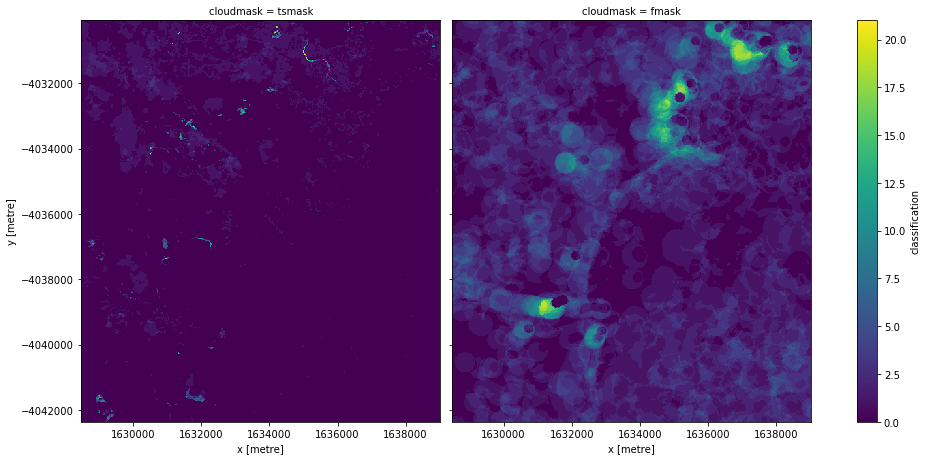

In [11]:
combined_ds = xr.concat([(tsmask_ds.classification == 3).sum(dim='time'), 
                         (s2_ds.fmask == 3).sum(dim='time')], dim='cloudmask')
combined_ds = combined_ds.assign_coords(cloudmask=['tsmask', 'fmask'])
combined_ds.plot(col='cloudmask', size=6.5, aspect=1)

## Plot example observations

### Comparing cloud masking

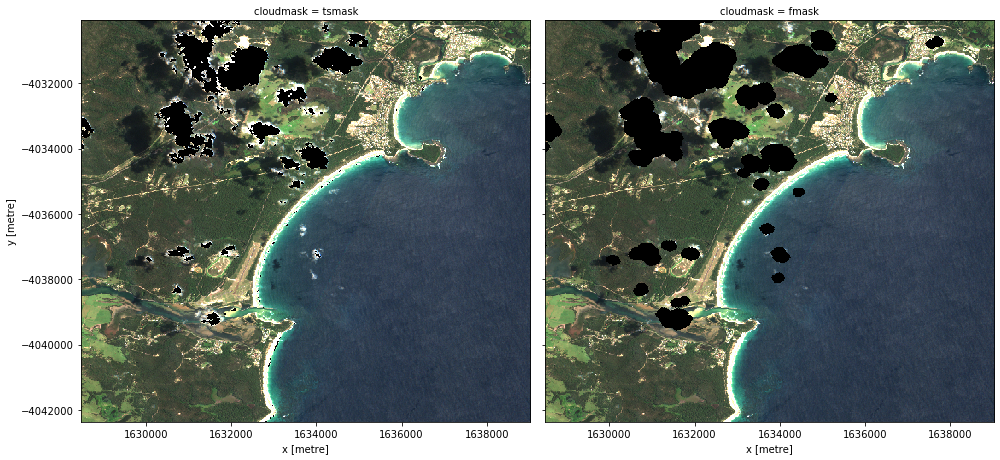

In [12]:
timestep = 39

rgb_data = s2_ds[['nbart_red', 'nbart_green', 'nbart_blue']]
combined_ds = xr.concat([rgb_data.where(tsmask_ds.classification != 2, other=0).isel(time=timestep).to_array(),
                         rgb_data.where(s2_ds.fmask != 2, other=0).isel(time=timestep).to_array()], dim='cloudmask')
combined_ds = combined_ds.assign_coords(cloudmask=['tsmask', 'fmask'])
combined_ds.plot.imshow(col='cloudmask', size=6.5, aspect=1, robust=True)


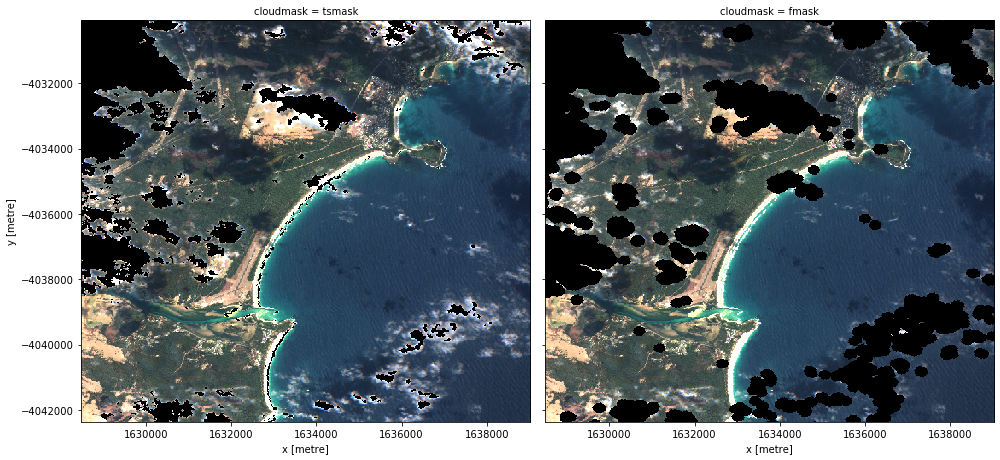

In [13]:
timestep = 7

rgb_data = s2_ds[['nbart_red', 'nbart_green', 'nbart_blue']]
combined_ds = xr.concat([rgb_data.where(tsmask_ds.classification != 2, other=0).isel(time=timestep).to_array(),
                         rgb_data.where(s2_ds.fmask != 2, other=0).isel(time=timestep).to_array()], dim='cloudmask')
combined_ds = combined_ds.assign_coords(cloudmask=['tsmask', 'fmask'])
combined_ds.plot.imshow(col='cloudmask', size=6.5, aspect=1, robust=True)

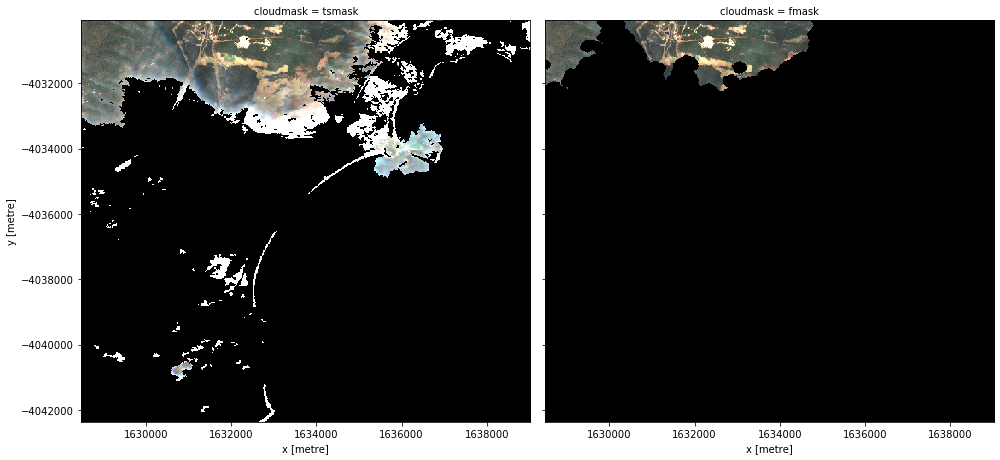

In [14]:
timestep = 8

rgb_data = s2_ds[['nbart_red', 'nbart_green', 'nbart_blue']]
combined_ds = xr.concat([rgb_data.where(tsmask_ds.classification != 2, other=0).isel(time=timestep).to_array(),
                         rgb_data.where(s2_ds.fmask != 2, other=0).isel(time=timestep).to_array()], dim='cloudmask')
combined_ds = combined_ds.assign_coords(cloudmask=['tsmask', 'fmask'])
combined_ds.plot.imshow(col='cloudmask', size=6.5, aspect=1, robust=True)

### Comparing cloud shadow masking

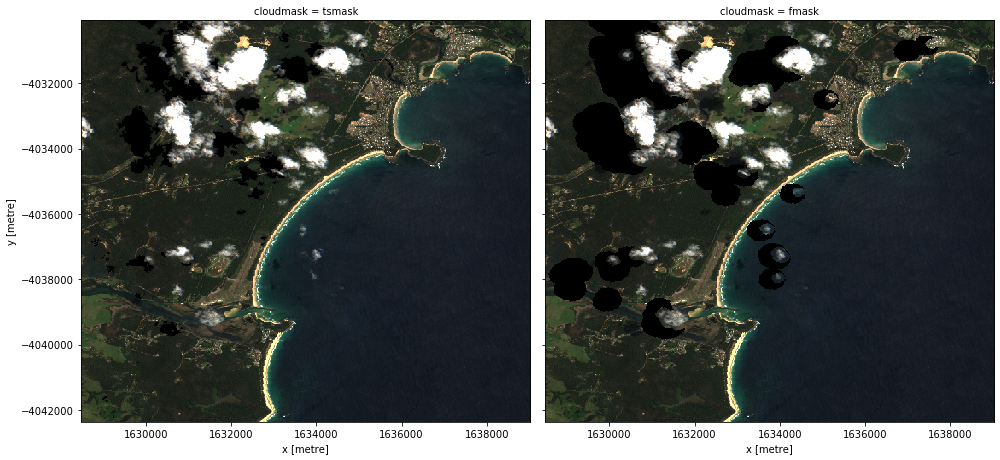

In [15]:
timestep = 39

rgb_data = s2_ds[['nbart_red', 'nbart_green', 'nbart_blue']]
combined_ds = xr.concat([rgb_data.where(tsmask_ds.classification != 3, other=0).isel(time=timestep).to_array(),
                         rgb_data.where(s2_ds.fmask != 3, other=0).isel(time=timestep).to_array()], dim='cloudmask')
combined_ds = combined_ds.assign_coords(cloudmask=['tsmask', 'fmask'])
combined_ds.plot.imshow(col='cloudmask', size=6.5, aspect=1, robust=True)


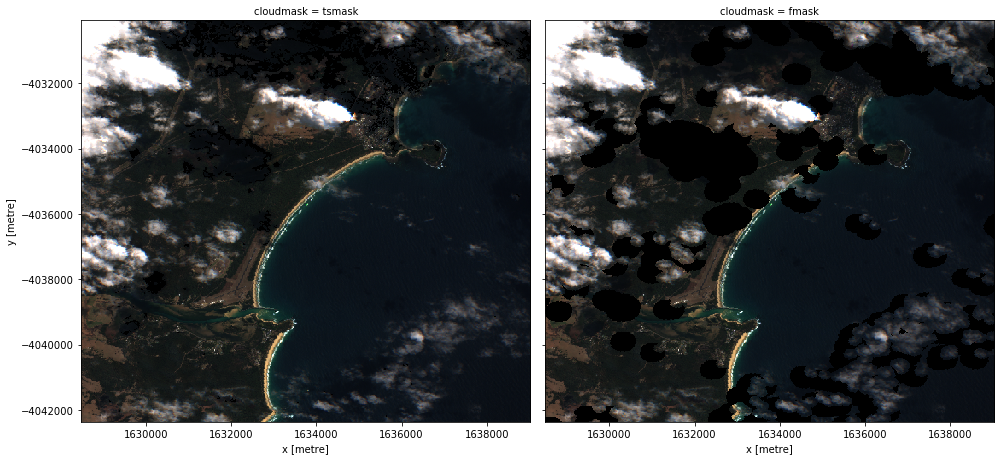

In [16]:
timestep = 7

rgb_data = s2_ds[['nbart_red', 'nbart_green', 'nbart_blue']]
combined_ds = xr.concat([rgb_data.where(tsmask_ds.classification != 3, other=0).isel(time=timestep).to_array(),
                         rgb_data.where(s2_ds.fmask != 3, other=0).isel(time=timestep).to_array()], dim='cloudmask')
combined_ds = combined_ds.assign_coords(cloudmask=['tsmask', 'fmask'])
combined_ds.plot.imshow(col='cloudmask', size=6.5, aspect=1, robust=True)

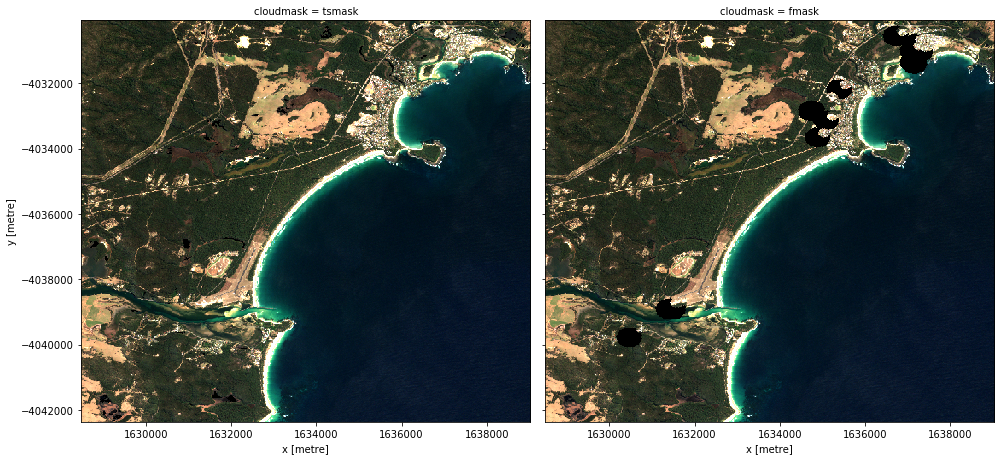

In [17]:
timestep = 9

rgb_data = s2_ds[['nbart_red', 'nbart_green', 'nbart_blue']]
combined_ds = xr.concat([rgb_data.where(tsmask_ds.classification != 3, other=0).isel(time=timestep).to_array(),
                         rgb_data.where(s2_ds.fmask != 3, other=0).isel(time=timestep).to_array()], dim='cloudmask')
combined_ds = combined_ds.assign_coords(cloudmask=['tsmask', 'fmask'])
combined_ds.plot.imshow(col='cloudmask', size=6.5, aspect=1, robust=True)